In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Data understanding

## Data loading

In [2]:
df = pd.read_csv('dataset_tagged.csv')
df.shape

(77983, 4)

In [3]:
df.head()

,First Name,Last Name,Management Level,Title
0,Ann,Beard,NaN,"Senior Manager, Enterprise Readiness"
1,Christy,Stropes,NaN,Senior Knowledge Management Coordinator
2,Eric,Kerr,NaN,NaN
3,Andrew,Beam,NaN,Work At Home Department Manager
4,Suzana,Djordjevic,Manager-Level,Director of Operations


## Data exploration

### Missing values

In [4]:
df.isna().sum()

First Name            37
Last Name              0
Management Level    1807
Title                403
dtype: int64

### Features

In [12]:
df['Title'].unique().shape

(46483,)

In [13]:
df['Management Level'].value_counts()

Director-Level    31449
VP-Level          29794
Manager-Level      7098
C-Level            4226
Other              3609
Name: Management Level, dtype: int64

In [14]:
# Unify categories

df['Management Level'] = np.where(
    df['Management Level'] == 'Non-Manager',
    'Other',
    df['Management Level']
)

df['Management Level'] = np.where(
    df['Management Level'] == 'Manager',
    'Manager-Level',
    df['Management Level']
)

df['Management Level'] = np.where(
    df['Management Level'] == 'Director',
    'Director-Level',
    df['Management Level']
)


# Fill NANs with default value

df['Management Level filled'] = np.where(
    df['Management Level'].isna(),
    'None',
    df['Management Level']
)

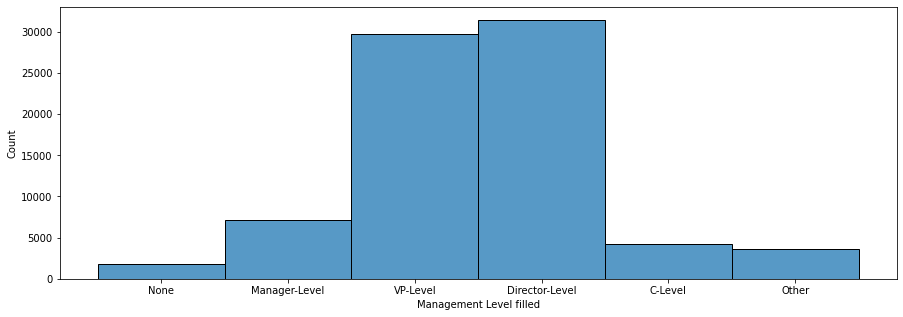

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['Management Level filled'], discrete=True, ax=ax)
plt.show()

## Correlations analysis